In [1]:
import numpy as np
import pandas as pd
import os, cv2, colorsys
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from collections import Counter
from sklearn.cluster import KMeans
from skimage.color import rgb2lab, deltaE_cie76, rgb2hsv

%matplotlib inline

---  
### COLOR WHEEL  

C:\Users\LAPTOP SHOP\AppData\Local\Temp\ipykernel_10832\2418712685.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cb = mpl.colorbar.ColorbarBase(display_axes, cmap=cm.get_cmap('hsv',quant_steps), norm=norm, orientation='horizontal')


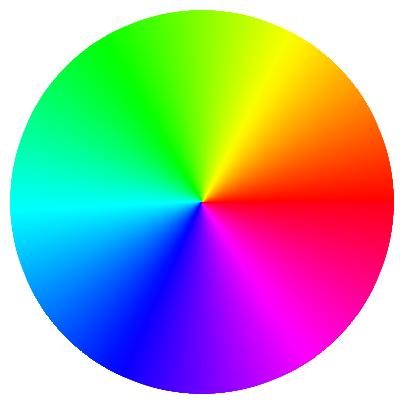

In [2]:
fig = plt.figure()

display_axes = fig.add_axes([0.1,0.1,0.8,0.8], projection='polar')
display_axes._direction = 2*np.pi
norm = mpl.colors.Normalize(0.0, 2*np.pi)

quant_steps = 2056
cb = mpl.colorbar.ColorbarBase(display_axes, cmap=cm.get_cmap('hsv',quant_steps), norm=norm, orientation='horizontal')

cb.outline.set_visible(False)                                 
display_axes.set_axis_off()
plt.show()

[]

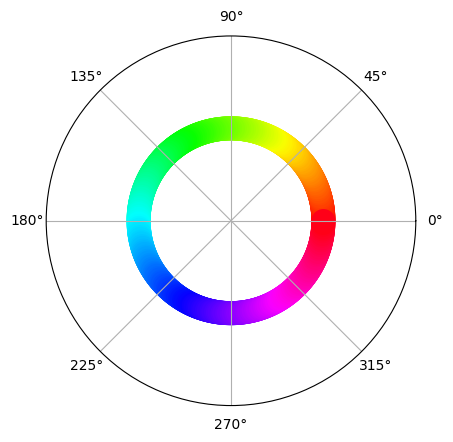

In [3]:
xval = np.arange(0, 2*np.pi, 0.01)
yval = np.ones_like(xval)

colormap = plt.get_cmap('hsv')
norm = mpl.colors.Normalize(0.0, 2*np.pi)

ax = plt.subplot(1, 1, 1, polar=True)
ax.scatter(xval, yval, c=xval, s=300, cmap=colormap, norm=norm, linewidths=0)
ax.set_yticks([])

---  
### HELPER FUNCTIONS  

In [4]:
def rgb2hex(val):
    """
    Takes tuple and converts to hex value.
    """
    conversion = '#%02x%02x%02x' % val
    return conversion

In [5]:
def hex2rgb(val):
    """
    Takes hex string and converts to rgb tuple.
    """
    hexNum = val.strip('#')
    hexLen = len(hexNum)
    conversion = tuple(int(hexNum[i:i+hexLen//3], 16) for i in range(0, hexLen, hexLen//3))
    return conversion

`complementary colors` : color that is 180 degrees apart from another color  
`split complimentary colors` : a base color and two colors that are 150 degrees and 210 degrees apart from the base color  
`analogous colors` : main color with the two colors directly next to it on the color wheel  
`triadic colors` : a main color and two colors that are 120 degrees and 240 degrees apart from the main color  
`tetradic colors` : a main color and three colors  that are 90 degrees, 180 degrees, and 270 degrees apart from the main color  

In [6]:
def complimentary(val):
    """
    Takes rgb tuple and produces complimentary color.
    """
    #value has to be 0 < x 1 in order to convert to hls
    r, g, b = map(lambda x: x/255.0, val)
    #hls provides color in radial scale
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    #get hue changes at 150 and 210 degrees
    deg_180_hue = h + (180.0 / 360.0)
    color_180_rgb = list(map(lambda x: round(x * 255),colorsys.hls_to_rgb(deg_180_hue, l, s)))
    return color_180_rgb

In [7]:
def splitComplimentary(val):
    """
    Takes rgb tuple and produces list of split complimentary colors.
    """
    #value has to be 0 <span id="mce_SELREST_start" style="overflow:hidden;line-height:0;"></span>&lt; x 1 in order to convert to hls
    r, g, b = map(lambda x: x/255.0, val)
    #hls provides color in radial scale
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    #get hue changes at 150 and 210 degrees
    deg_150_hue = h + (150.0 / 360.0)
    deg_210_hue = h + (210.0 / 360.0)
    #convert to rgb
    color_150_rgb = list(map(lambda x: round(x * 255),colorsys.hls_to_rgb(deg_150_hue, l, s)))
    color_210_rgb = list(map(lambda x: round(x * 255),colorsys.hls_to_rgb(deg_210_hue, l, s)))
    return [color_150_rgb, color_210_rgb]

In [8]:
def analogous(val, d):
    """
    Takes rgb tuple and angle (out of 100) and produces list of analogous colors)
    """
    analogous_list = []
    #set color wheel angle
    d = d /360.0
    #value has to be 0 <span id="mce_SELREST_start" style="overflow:hidden;line-height:0;"></span>&lt; x 1 in order to convert to hls
    r, g, b = map(lambda x: x/255.0, val)
    #hls provides color in radial scale
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    #rotate hue by d
    h = [(h+d) % 1 for d in (-d, d)]
    for nh in h:
        new_rgb = list(map(lambda x: round(x * 255),colorsys.hls_to_rgb(nh, l, s)))
        analogous_list.append(new_rgb)
    return analogous_list

In [9]:
def triadic(val):
    """
    Takes rgb tuple and produces list of triadic colors.
    """
    #value has to be 0 < x 1 in order to convert to hls
    r, g, b = map(lambda x: x/255.0, val)
    #hls provides color in radial scale
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    #get hue changes at 120 and 240 degrees
    deg_120_hue = h + (120.0 / 360.0)
    deg_240_hue = h + (240.0 / 360.0)
    #convert to rgb
    color_120_rgb = list(map(lambda x: round(x * 255),colorsys.hls_to_rgb(deg_120_hue, l, s)))
    color_240_rgb = list(map(lambda x: round(x * 255),colorsys.hls_to_rgb(deg_240_hue, l, s)))
    return [color_120_rgb, color_240_rgb]

In [10]:
def tetradic(val):
    """
    Takes rgb tuple and produces list of tetradic colors.
    """
    #value has to be 0 <span id="mce_SELREST_start" style="overflow:hidden;line-height:0;"></span>&lt; x 1 in order to convert to hls
    r, g, b = map(lambda x: x/255.0, val)
    #hls provides color in radial scale
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    #get hue changes at 120 and 240 degrees
    deg_60_hue = h + (60.0 / 360.0)
    deg_180_hue = h + (180.0 / 360.0)
    deg_240_hue = h + (240.0 / 360.0)
    #convert to rgb
    color_60_rgb = list(map(lambda x: round(x * 255),colorsys.hls_to_rgb(deg_60_hue, l, s)))
    color_180_rgb = list(map(lambda x: round(x * 255),colorsys.hls_to_rgb(deg_180_hue, l, s)))
    color_240_rgb = list(map(lambda x: round(x * 255),colorsys.hls_to_rgb(deg_240_hue, l, s)))
    return [color_60_rgb, color_180_rgb, color_240_rgb]

In [11]:
def createRange(clr, margin=10):
    r, g, b = clr
    rRange = set(range(r-margin, r+margin))
    gRange = set(range(g-margin, g+margin))
    bRange = set(range(b-margin, b+margin))
    print(f"r Range : {rRange}\ng Range : {gRange}\nb Range : {bRange}\n")
    return rRange, gRange, bRange

In [12]:
def checkClr(clr, rRange, gRange, bRange, match=False):
    if (clr[0] not in rRange) and (clr[1] not in gRange) and (clr[2] not in bRange):
        print("colors are out of range ! try another piece")
    else:
        print("colors are all safe !\ncolors are a good match !")
        match = True
    return match

---  
### TESTING FUNCTIONS   

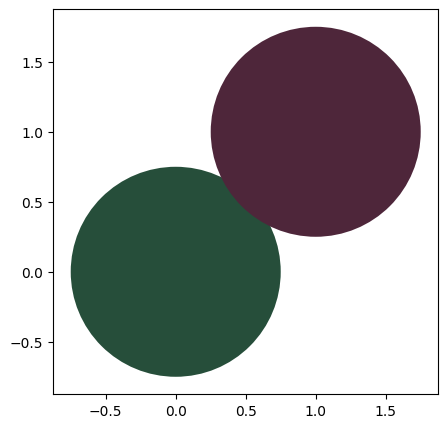

In [13]:
rgb_eden = (38, 78, 58)
comp_col = complimentary(rgb_eden)
 
#Visualize Colors
hexVal = rgb2hex((78, 38, 58))
edenHex = rgb2hex(rgb_eden)
fig = plt.gcf()
fig.set_size_inches(5, 5, forward=True)
 
plt.axes()
 
circle = plt.Circle((0, 0), radius=0.75, fc=edenHex)
circle2 = plt.Circle((1, 1), radius=0.75, fc=hexVal)
plt.gca().add_patch(circle)
plt.gca().add_patch(circle2)
 
plt.axis('scaled')
plt.show()

---  
### MAIN  

In [14]:
match = False

In [15]:
clr01, clr02 = [38, 78, 58], [78, 38, 58]
print(f"clr 01 : {clr01}, {type(clr01)}\nclr 02 : {clr02}, {type(clr02)}")

clrComp = comp_col
print(f"clr computed : {clrComp}, {type(clrComp)}")

clr 01 : [38, 78, 58], <class 'list'>
clr 02 : [78, 38, 58], <class 'list'>
clr computed : [78, 38, 58], <class 'list'>


In [16]:
rRange, gRange, bRange = createRange(clrComp, 10)

r Range : {68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87}
g Range : {28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47}
b Range : {48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67}



In [17]:
checkClr(clr02, rRange, gRange, bRange, match)

colors are all safe !
colors are a good match !


True

In [18]:
checkClr([34, 50, 80], rRange, gRange, bRange, match)

colors are out of range ! try another piece


False